#Convolutional Neural Network
The goal of this assignment is to implement the convolutional neural network Pytorch to perform classification and test it out on the CIFAR-10 dataset. All the code will be implemented in this notebook.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/capstone/clip_images/

/content/gdrive/MyDrive/capstone/clip_images


First, let's install modules not already installed by Google Colab.

In [3]:
! pip install torch_utils

  Created wheel for torch-utils: filename=torch_utils-0.1.2-py3-none-any.whl size=6202 sha256=cca6fda1bbd029a693a1987bc66507ba5a2e2f757590dacd7c5eb0749132783e
  Stored in directory: /root/.cache/pip/wheels/5d/c0/1d/a539c1c2a4d41c5d7109899289cded24fe1320b6a6c7b02a4c
Successfully built torch-utils


## Task 1: Design Your Convolutional Neural Network

In the begining, please import all the package you need. We provide some packages here, which might be helpful when you build your code.

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, sampler
import torch.nn.functional as F
from torch_utils import AverageMeter
import math
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sklearn.metrics import mean_squared_error
from numpy import inf
import torchvision
import cv2

from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torch import optim, cuda, Tensor
import tqdm

# Data science tools
import numpy as np

import os

# Image manipulations
from PIL import Image
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
#plt.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Then, you need to define a class for your CNN. The network should be two conv layers, two pool layers, and three linear layers. You can follow the instruction to build your network.


In [5]:
# define model
class bmodel(nn.Module):
    def __init__(self):
        super(bmodel, self).__init__()
        # Define all the layers that you need in your network
        # You can use nn.Conv2d() to define the 2d convolutional layer
        # You can use nn.MaxPool2d() to define the 2d maxpooling layer
        # You can use nn.Linear() to define the linear layer
        # You can use F.relu() to define your ReLu layer
        ######################
        ### YOUR CODE HERE ###
        ######################
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(10, 20, 4)
        self.fc1 = nn.Linear(20 * 5 * 5, 250)
        self.fc2 = nn.Linear(250, 50)
        self.fc3 = nn.Linear(50, 2)
        self.dropout = nn.Dropout(0.5)
        #####################
        ### YOUR CODE END ###
        #####################

    def forward(self, x):
        # You may use x.view() to reshape the tensor.
        ######################
        ### YOUR CODE HERE ###
        ######################
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))  
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
        #####################
        ### YOUR CODE END ###
        #####################

model = bmodel()

Cuda is Compute Unified Device Architecture, which can achieve parallel computing. It will improve your learning speed in your parameter update by using GPU rather than CPU.

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 27 23:34:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [7]:
# Check whether there is a gpu for cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
else:
    multi_gpu = False
print(train_on_gpu,multi_gpu)

if train_on_gpu:
    model = model.to('cuda')


Train on gpu: True
1 gpus detected.
True False


First, we will use the CIFAR-10 dataset to train our model. In HW2 and HW3, we simply define a two-layer-network with linear layers. Therefore, we reshaped each image in one dimension when loading the data. In this assignment, we need to reshape our dataset within this shape [image number, rgb channels, height, weight] to match the convolutional network.

### Read in the all data and its prediction labels

In [9]:
all_data = np.load("training.npy")
all_labels = np.load("pred.npy")

### Create a channel in the first dimension of all data

In [10]:
all_ex_data = np.expand_dims(all_data, axis=1)

### Split all data into training (80%) and validation (20%) set

In [11]:
train_ind = np.random.choice(all_ex_data.shape[0], int(all_ex_data.shape[0] * 0.8), replace=False)
valid_ind = np.setdiff1d(range(all_ex_data.shape[0]), train_ind)

train_X = all_ex_data[train_ind]
train_Y = all_labels[train_ind]

validation_X = all_ex_data[valid_ind]
validation_Y = all_labels[valid_ind]

print('Train data shape: ', train_X.shape)
print('Train labels shape: ', train_Y.shape)
print('Validation data shape: ', validation_X.shape)
print('Validation labels shape: ', validation_Y.shape)

Train data shape:  (873, 1, 28, 28)
Train labels shape:  (873,)
Validation data shape:  (219, 1, 28, 28)
Validation labels shape:  (219,)


We can use the same code in HW3 for dataloader.


In [13]:
# Datasets organization
batch_size = 20

# Transfer the data from numpy to tensor
# You can use the same code in HW3
######################
### YOUR CODE HERE ###
######################
data = {
    'train':
    TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_Y).float()),
    'valid':
    ######################
    ### YOUR CODE HERE ###
    ######################
    TensorDataset(torch.from_numpy(validation_X), torch.from_numpy(validation_Y).float())
    #####################
    ### YOUR CODE END ###
    #####################

}
#####################
### YOUR CODE END ###
#####################

# Dataloader iterators, make sure to shuffle
# You can use the same code in HW3
######################
### YOUR CODE HERE ###
######################
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'valid':
    ######################
    ### YOUR CODE HERE ###
    ######################
    DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=10)
    ######################
    ### YOUR CODE END ###
    ######################
}
#####################
### YOUR CODE END ###
#####################


# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
validationiter = iter(dataloaders['valid'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


CIFAR-10 has 10 classes, which are shown below. We can print the images with labels to verify the dataset. Since we've reshaped our image data for training, they need to be reshaped for printing.

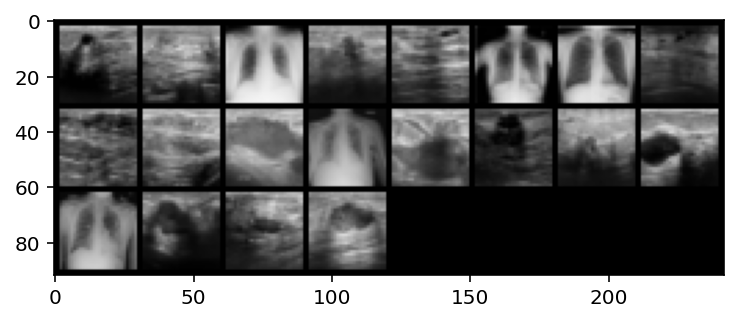

     chest    breast    breast    chest    breast    chest    chest    breast    breast    breast    breast    chest    breast    chest    breast    breast    chest    breast    chest    breast


In [14]:
classes = ("breast", "chest")

# functions to show an image

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    # Reshape the image from [rgb_channel, weight, height] to [weight, height, rgb_channel]
    # You can use np.transpose() to reorder the dimensions
    ######################
    ### YOUR CODE HERE ###
    ######################
    npimg = np.transpose(npimg, (1, 2, 0))
    #####################
    ### YOUR CODE END ###
    #####################
    plt.imshow(npimg)
    plt.show()


# get some random training images
# you may use .next() to get the next iteration of training dataloader
######################
### YOUR CODE HERE ###
######################
images, labels = trainiter.next()
#####################
### YOUR CODE END ###
#####################


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("     " + '    '.join('%5s' % classes[labels[j].long()] for j in range(batch_size)))

Looks good! Now we may set up the loss function and theoptimizer tool.

In [16]:
# Set up your criterion and optimizer
# You can use nn.CrossEntropyLoss() as your critenrion
# You can use optim.SGD() as your optimizer

#####################
### YOUR CODE HERE###
#####################
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
####################
### YOUR CODE END###
####################

Now we can use the training process in HW3 to train our CNN.

In [17]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=10,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()

        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            
            # Tensors to gpu, both model parameters, data, and target need to be tensors.
            # You can use .cuda() function
            ######################
            ### YOUR CODE HERE ###
            ######################
            model.cuda()
            data = data.cuda()
            target = target.cuda()
            #####################
            ### YOUR CODE END ###
            #####################

            # Clear gradients
            optimizer.zero_grad()

            # Forward path
            ######################
            ### YOUR CODE HERE ###
            ######################
            output = model(data.float())
            #####################
            ### YOUR CODE END ###
            #####################

            # Loss function 
            ######################
            ### YOUR CODE HERE ###
            ######################
            loss = criterion(output, target.long())
            #####################
            ### YOUR CODE END ###
            #####################

            # Backward path (backpropagation)
            ######################
            ### YOUR CODE HERE ###
            ######################
            loss.backward()
            #####################
            ### YOUR CODE END ###
            #####################

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))

            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():

                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    data = data.cuda()
                    target = target.cuda()
                    #####################
                    ### YOUR CODE END ###
                    #####################

                    # Forward path
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    output = model(data.float())
                    #####################
                    ### YOUR CODE END ###
                    #####################

                    # Validation loss computation
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    loss = criterion(output, target.long())
                    #####################
                    ### YOUR CODE END ###
                    #####################

                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))

                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)


                # Calculate average losses and Calculate average accuracy
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model 
                    # You can use torch.save()
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    torch.save(model.state_dict(), save_file_name)
                    #####################
                    ### YOUR CODE END ###
                    #####################

                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        # You can use model.load_state_dict()
                        ######################
                        ### YOUR CODE HERE ###
                        ######################
                        model.load_state_dict(torch.load(save_file_name))
                        #####################
                        ### YOUR CODE END ###
                        #####################

                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

Once we set up everything, we can start to train our CNN.

In [18]:
from timeit import default_timer as timer
save_file_name = f'CNN_model_best_model.pt'
train_on_gpu = cuda.is_available()

model, history = train(model,
    criterion,
    optimizer,
    dataloaders['train'], 
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop= 10,
    n_epochs=20,
    print_every=1)

Starting Training from Scratch.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch: 0 	Training Loss: 0.7963 	Validation Loss: 0.6619
		Training Accuracy: 52.81%	 Validation Accuracy: 57.53%

Epoch: 1 	Training Loss: 0.6525 	Validation Loss: 0.5529
		Training Accuracy: 63.00%	 Validation Accuracy: 80.82%

Epoch: 2 	Training Loss: 0.5879 	Validation Loss: 0.5426
		Training Accuracy: 69.87%	 Validation Accuracy: 79.91%

Epoch: 3 	Training Loss: 0.5860 	Validation Loss: 0.5173
		Training Accuracy: 72.74%	 Validation Accuracy: 79.45%

Epoch: 4 	Training Loss: 0.5940 	Validation Loss: 0.5105
		Training Accuracy: 71.48%	 Validation Accuracy: 79.45%

Epoch: 5 	Training Loss: 0.5622 	Validation Loss: 0.5288
		Training Accuracy: 75.37%	 Validation Accuracy: 78.54%

Epoch: 6 	Training Loss: 0.5420 	Validation Loss: 0.5093
		Training Accuracy: 75.95%	 Validation Accuracy: 79.91%

Epoch: 7 	Training Loss: 0.5355 	Validation Loss: 0.5467
		Training Accuracy: 77.55%	 Validation Accuracy: 79.00%

Epoch: 8 	Training Loss: 0.5326 	Validation Loss: 0.4941
		Training Accuracy: 7

At this time, we use CNN, which can get better features from images than two-layer-network. The results should be better than HW3. Now, we can check the losses and accuracy during the training.

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

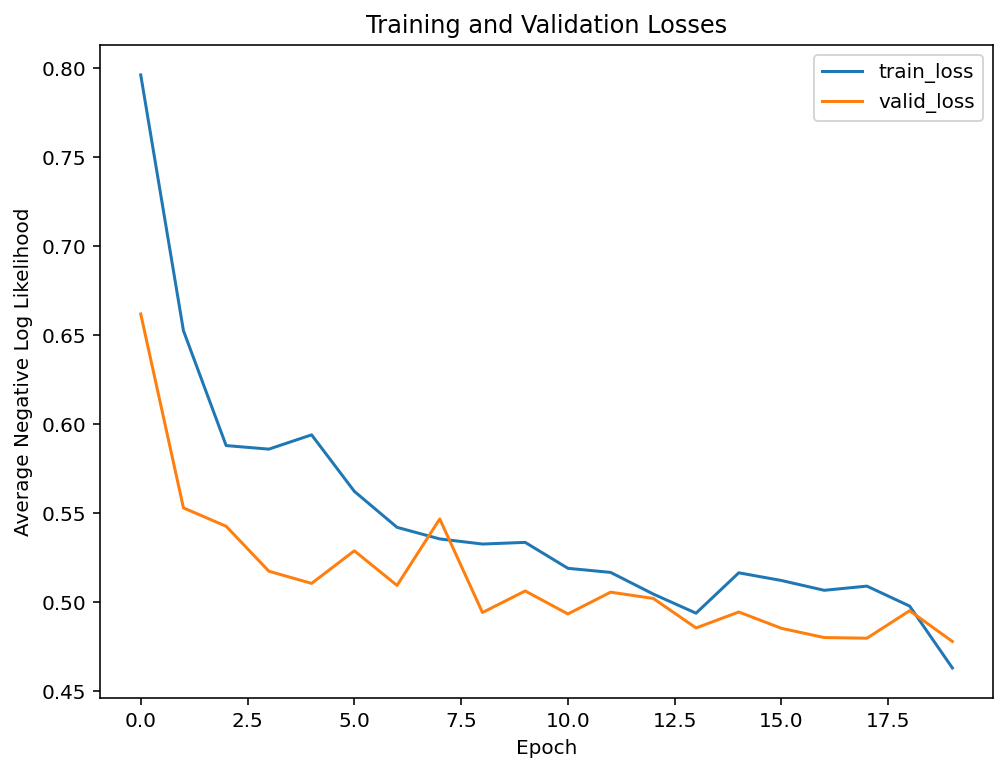

In [19]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

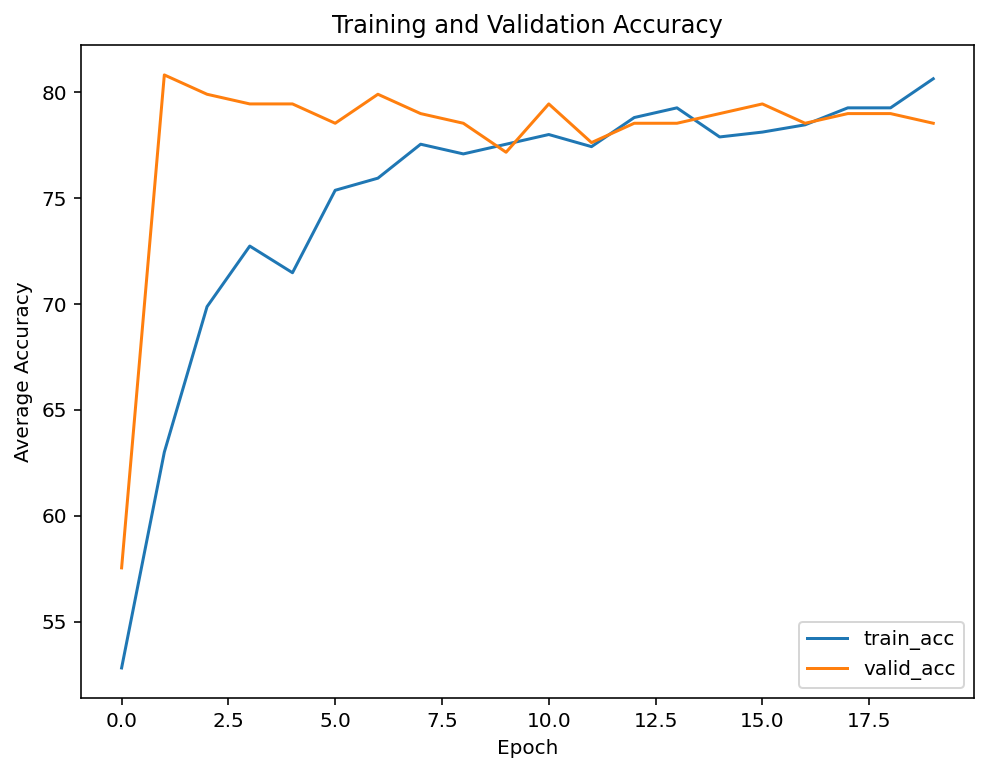

In [20]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

A big progress! You may wondering whether your network can predict correctly. You may use your model to get the prediction with validationset.

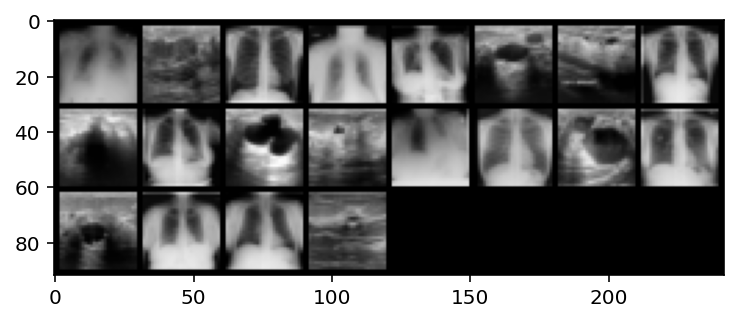

GroundTruth:  chest breast chest chest breast breast breast chest breast chest chest breast breast chest breast chest breast breast breast chest
Prediction:  chest breast chest chest chest breast breast chest breast chest breast breast chest chest breast chest breast chest chest breast


In [21]:
dataiter = iter(validationiter)
# get some random training images
images, labels = dataiter.next()

# Get the prediction of images by using your model.
outputs = model(images.cuda().float())
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j].long()] for j in range(batch_size)))
print('Prediction: ', ' '.join('%5s' % classes[predicted[j].long()] for j in range(batch_size)))

### Apply this trained model on test set of breast and chest

#### Read in data

In [22]:
breast_path = '../data/breastmnist.npz'
breast = np.load(breast_path)
print("Breast validation dataset shape:", breast['val_images'].shape)
print("Breast test dataset shape:", breast['test_images'].shape)
print("Breast dataset first three labels:", breast['val_labels'][:3])

chest_path = '../data/chestmnist.npz'
chest = np.load(chest_path)
print("Chest validation dataset shape:", chest['val_images'].shape)
print("Chest test dataset shape:", chest['test_images'].shape)
print("Chest dataset first three labels", chest['val_labels'][:3])

Breast validation dataset shape: (78, 28, 28)
Breast test dataset shape: (156, 28, 28)
Breast dataset first three labels: [[0]
 [1]
 [1]]
Chest validation dataset shape: (11219, 28, 28)
Chest test dataset shape: (22433, 28, 28)
Chest dataset first three labels [[0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


### Evaluate predictions on valid and test set

#### Create the true labels for test set

In [23]:
test_breast = np.concatenate([breast['val_images'], breast['test_images']], axis=0)
test_chest = np.concatenate([chest['val_images'], chest['test_images']], axis=0)
random_chest_ind = np.random.choice(a=test_chest.shape[0], size=test_breast.shape[0])
test_chest = test_chest[random_chest_ind]
test = np.concatenate([test_breast, test_chest], axis=0)
true_labels = [0]*test_breast.shape[0] + [1]*test_chest.shape[0]

#### Expand one dimension of channel for test set

In [24]:
test_channel = np.expand_dims(test, axis=1)
test_channel.shape

(468, 1, 28, 28)

#### Get predictions on test set

In [ ]:
#model = bmodel()
#model.load_state_dict(torch.load("CNN_model_best_model.pt"))
#model.cuda()

<All keys matched successfully>

bmodel(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [25]:
outputs = model(torch.from_numpy(test_channel).cuda().float())
_, predicted = torch.max(outputs, 1)
(np.array(true_labels) == np.array(predicted.tolist())).sum() / len(true_labels)

0.9615384615384616

## Compare above test accuracy with zero-shot classification

In [26]:
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-88kffioo
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-88kffioo
     |████████████████████████████████| 53 kB 1.6 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369389 sha256=774230ddad72a0adf493c1c59ac0cefd31d59b3537975242128af09bb74fd3f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-3_b251ru/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [27]:
import clip

clip.available_models()

clip_model, preprocess = clip.load("ViT-L/14")
clip_model.cuda().eval()
input_resolution = clip_model.visual.input_resolution
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

100%|███████████████████████████████████████| 890M/890M [00:15<00:00, 60.7MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)


Model parameters: 427,616,513
Input resolution: 224
Context length: 77
Vocab size: 49408


In [28]:
uni_labels = ['breast', 'chest']
text_descriptions = [f"This is a photo of {label}, and it's a type of organ." for label in uni_labels]
text_tokens = clip.tokenize(text_descriptions).cuda()

with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

SS = test.shape[0]
original_images = [Image.fromarray(test[j]) for j in range(SS)]

images = [preprocess(j) for j in original_images]
image_input = torch.tensor(np.stack(images)).cuda()

with torch.no_grad():
    image_features = clip_model.encode_image(image_input).float()

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(1, dim=-1)

pred_labels = np.squeeze(top_labels).numpy()
(true_labels == pred_labels).sum() / len(true_labels)

0.7991452991452992

##Task 2: Improve your performance
Here, we may (1) add more layers to make the network deeper, or (2) replace your bmodel() with networks provided by PyTorch. https://pytorch.org/vision/0.8/models.html
You just need to do one of these two options.

You can reuse the code you have from Task 1

### (2) replace your bmodel() with networks provided by PyTorch

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier.   
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './datasets/'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: 
    X_train = X_train/X_train.max()
    X_val = X_val/X_val.max()
    X_test = X_test/X_test.max()


    #Reshape data
    # The shape should be [image number, rgb channels, height, weight]
    # You can use np.moveaxis() to change the dimension order
    ######################
    ### YOUR CODE HERE ###
    ######################
    X_train = np.moveaxis(X_train, -1, 1)
    X_val = np.moveaxis(X_val, -1, 1)
    X_test = np.moveaxis(X_test, -1, 1)
    #####################
    ### YOUR CODE END ###
    #####################

    return X_train, y_train, X_val, y_val, X_test, y_test


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
train_X, train_Y, validation_X, validation_Y, test_X, test_Y = get_CIFAR10_data()
print('Train data shape: ', train_X.shape)
print('Train labels shape: ', train_Y.shape)
print('Validation data shape: ', validation_X.shape)
print('Validation labels shape: ', validation_Y.shape)
print('Test data shape: ', test_X.shape)
print('Test labels shape: ', test_Y.shape)

### Resize the images from 32 by 32 to 224 by 224 and normalize them by mean and sd provided by sites: https://pytorch.org/vision/0.8/models.html

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

#### We only use first part (around 8,000) out of the whole triaining size (49,000), because this colab session RAM is unable to hold larger numpy array.

In [ ]:
############ Normalize training sample
S = 8000
res_train_X = np.empty(shape=(S, train_X.shape[1], 224, 224))
mean_sd = {"mean": [0.485, 0.456, 0.406], "sd": [0.229, 0.224, 0.225]}
for i in range(S):
  for j in range(train_X.shape[1]):
    res_train_X[i, j, :, :] = cv2.resize(train_X[i, j, :, :], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    res_train_X[i, j, :, :] = res_train_X[i, j, :, :] - mean_sd["mean"][j]
    res_train_X[i, j, :, :] = res_train_X[i, j, :, :] / mean_sd["sd"][j]

In [ ]:
########### Normalize validation sample
res_valid_X = np.empty(shape=(1000, 3, 224, 224))
for i in range(1000):
  for j in range(3):
    res_valid_X[i, j, :, :] = cv2.resize(validation_X[i, j, :, :], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    res_valid_X[i, j, :, :] = res_valid_X[i, j, :, :] - mean_sd["mean"][j]
    res_valid_X[i, j, :, :] = res_valid_X[i, j, :, :] / mean_sd["sd"][j]

In [ ]:
# Datasets organization
batch_size = 10

# Transfer the data from numpy to tensor
# You can use the same code in HW3
######################
### YOUR CODE HERE ###
######################
data = {
    'train':
    TensorDataset(torch.from_numpy(res_train_X), torch.from_numpy(train_Y)[:S].float()),
    'valid':
    ######################
    ### YOUR CODE HERE ###
    ######################
    TensorDataset(torch.from_numpy(res_valid_X), torch.from_numpy(validation_Y).float())
    #####################
    ### YOUR CODE END ###
    #####################

}
#####################
### YOUR CODE END ###
#####################

# Dataloader iterators, make sure to shuffle
# You can use the same code in HW3
######################
### YOUR CODE HERE ###
######################
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'valid':
    ######################
    ### YOUR CODE HERE ###
    ######################
    DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=10)
    ######################
    ### YOUR CODE END ###
    ######################
}
#####################
### YOUR CODE END ###
#####################


# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
validationiter = iter(dataloaders['valid'])

# get some random training images
# you may use .next() to get the next iteration of training dataloader
######################
### YOUR CODE HERE ###
######################
images, labels = trainiter.next()
#####################
### YOUR CODE END ###
#####################


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j].long()] for j in range(batch_size)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 1 Axes>

 deer truck   dog horse plane   dog truck truck   dog   cat


#### First we used AlexNet as our pretrain model to train our CNN

In [ ]:
#### Choose AlexNet as our pretrained model
alexnet = models.alexnet(pretrained=True)
############################################

################################################################################
### Check alexnet input and output dimension, so we have to change output dimension to 10
alexnet.eval()
################################################################################

#############################################################
### Change its default architecture to fit our cifar-10 data
alexnet.classifier[1] = nn.Linear(9216,4096)
alexnet.classifier[4] = nn.Linear(4096,1024)
alexnet.classifier[6] = nn.Linear(1024,10)
##############################################################

########################################################################
### Get GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
########################################################################

###############################
### Move alexnet to GPU device
alexnet.to(device)
###############################

#####################################################################
### Train our normalized data using modified Alexnet 
from timeit import default_timer as timer
save_file_name = f'cifar_fromURL_model_best_model.pt'
train_on_gpu = cuda.is_available()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

model_alex, history_alex = train(alexnet,
    criterion,
    optimizer,
    dataloaders['train'], 
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop = 10,
    n_epochs = 50,
    print_every=1)
#####################################################################

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Starting Training from Scratch.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch: 0 	Training Loss: 1.1842 	Validation Loss: 0.7802
		Training Accuracy: 57.74%	 Validation Accuracy: 73.70%

Epoch: 1 	Training Loss: 0.6881 	Validation Loss: 0.6231
		Training Accuracy: 76.24%	 Validation Accuracy: 79.50%

Epoch: 2 	Training Loss: 0.5190 	Validation Loss: 0.6041
		Training Accuracy: 82.10%	 Validation Accuracy: 80.90%

Epoch: 3 	Training Loss: 0.3836 	Validation Loss: 0.6613
		Training Accuracy: 86.62%	 Validation Accuracy: 79.00%

Epoch: 4 	Training Loss: 0.3027 	Validation Loss: 0.6939
		Training Accuracy: 89.36%	 Validation Accuracy: 79.70%

Epoch: 5 	Training Loss: 0.2383 	Validation Loss: 0.6496
		Training Accuracy: 92.01%	 Validation Accuracy: 80.00%

Epoch: 6 	Training Loss: 0.2064 	Validation Loss: 0.6452
		Training Accuracy: 92.46%	 Validation Accuracy: 83.10%

Epoch: 7 	Training Loss: 0.1616 	Validation Loss: 0.6904
		Training Accuracy: 94.35%	 Validation Accuracy: 83.30%

Epoch: 8 	Training Loss: 0.1472 	Validation Loss: 0.7870
		Training Accuracy: 9

#### Please plot the figures and show the prediction of your network of AlexNet model.

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history_alex[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

<Figure size 576x432 with 1 Axes>

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history_alex[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

<Figure size 576x432 with 1 Axes>

#### Predict on validation set

In [ ]:
dataiter = iter(validationiter)
# get some random training images
images, labels = dataiter.next()

# Get the prediction of images by using your model.
outputs = alexnet(images.cuda().float())
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j].long()] for j in range(batch_size)))
print('Prediction: ', ' '.join('%5s' % classes[predicted[j].long()] for j in range(batch_size)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 1 Axes>

GroundTruth:   bird horse  deer  deer  deer   cat   car   cat  frog horse
Prediction:   bird   cat horse horse  deer   dog   car   cat  frog horse


#### Secondly We used wide_resnet50_2 pretrained model to train our CNN

In [ ]:
########### Choose ResNet as our pretrained model
resnet = models.wide_resnet50_2(pretrained=True)
#################################################

################################################################################
### Check ResNet input and output dimension, so we have to change output 
### dimension to 10
resnet.eval()
################################################################################

################################################################################
### Chenge the default design to fit the 10 output classes
resnet.fc = nn.Linear(2048, 10)
################################################################################

########################################################################
### Get GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
########################################################################

###############################
### Move alexnet to GPU device
resnet.to(device)
###############################

################################################################################
### Train our normalized data using modified Alexnet 
from timeit import default_timer as timer
save_file_name = f'cifar_resnet_model_best_model.pt'
train_on_gpu = cuda.is_available()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

model_resnet, history_resnet = train(resnet,
    criterion,
    optimizer,
    dataloaders['train'], 
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop = 5,
    n_epochs = 50,
    print_every=1)
################################################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

Starting Training from Scratch.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch: 0 	Training Loss: 0.7369 	Validation Loss: 0.3103
		Training Accuracy: 76.32%	 Validation Accuracy: 89.50%

Epoch: 1 	Training Loss: 0.2896 	Validation Loss: 0.2469
		Training Accuracy: 90.55%	 Validation Accuracy: 91.90%

Epoch: 2 	Training Loss: 0.1680 	Validation Loss: 0.2402
		Training Accuracy: 94.64%	 Validation Accuracy: 92.50%

Epoch: 3 	Training Loss: 0.1081 	Validation Loss: 0.2825
		Training Accuracy: 96.57%	 Validation Accuracy: 91.20%

Epoch: 4 	Training Loss: 0.0663 	Validation Loss: 0.2116
		Training Accuracy: 98.04%	 Validation Accuracy: 93.70%

Epoch: 5 	Training Loss: 0.0440 	Validation Loss: 0.2128
		Training Accuracy: 98.82%	 Validation Accuracy: 93.70%

Epoch: 6 	Training Loss: 0.0371 	Validation Loss: 0.2470
		Training Accuracy: 98.94%	 Validation Accuracy: 93.90%

Epoch: 7 	Training Loss: 0.0351 	Validation Loss: 0.1954
		Training Accuracy: 99.01%	 Validation Accuracy: 94.50%

Epoch: 8 	Training Loss: 0.0266 	Validation Loss: 0.2166
		Training Accuracy: 9

#### Please plot the figures and show the prediction of your network of ResNet model.

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history_resnet[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

<Figure size 576x432 with 1 Axes>

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history_resnet[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

<Figure size 576x432 with 1 Axes>

#### Predict on validation set

In [ ]:
dataiter = iter(validationiter)
# get some random training images
images, labels = dataiter.next()

# Get the prediction of images by using your model.
outputs = resnet(images.cuda().float())
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j].long()] for j in range(batch_size)))
print('Prediction: ', ' '.join('%5s' % classes[predicted[j].long()] for j in range(batch_size)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 1 Axes>

GroundTruth:    car  deer  frog   car  bird  ship  ship  bird  frog horse
Prediction:    car  deer  frog   car  bird  ship  ship  bird  frog horse


## Summary

I used two kinds of pretrain models. The first method is to use pretrained model alexnet provided by Pytorch. The notice thing is that when I used all pretrained models, we need to resize the input shape to the requirment one at least 224*224 then normaliza them by using their predefined mean and standard deviation. Another noticable thing is that we need to change some linear layer input and output shapes of architecture so thet this alexnet model is able to fit our cifar-10 images including 10 classes. So, I resized and normalized our cifar-10 images as required. The result plots show that best validation accuracy is around 80% and the lowest validation error is about 0.58, this is much better than our initial neural network model with only 60% accuracy and 1.13 validation error.

The second pretrained model is called wide_resnet50_2. I also need to resize and normalize our input images and change the default architure of CNN to fit the final 10 outputs. We only used 8000 training sample and 1000 validation set, we got much better results. We got about 94% validation accuracy and 0.17 validation error.